In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gc
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime

In [2]:
df = pd.read_csv('taobao_persona.csv')
df.head()

,user_id,item_id,behavior_type,user_geohash,item_category,time
0,10001082,285259775,1,97lk14c,4076,2014-12-08 18
1,10001082,4368907,1,NaN,5503,2014-12-12 12
2,10001082,4368907,1,NaN,5503,2014-12-12 12
3,10001082,53616768,1,NaN,9762,2014-12-02 15
4,10001082,151466952,1,NaN,5232,2014-12-12 11


In [4]:
# sample 20%, dataset too large
df_use = df.sample(frac=0.2, random_state=None)
df_use.shape

(4658205, 6)

In [5]:
del df
gc.collect()

979

In [7]:
df = df_use
del df_use
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4658205 entries, 12419438 to 3621533
Data columns (total 6 columns):
user_id          int64
item_id          int64
behavior_type    int64
user_geohash     object
item_category    int64
time             object
dtypes: int64(4), object(2)
memory usage: 248.8+ MB


In [8]:
df.isnull().sum()

user_id                0
item_id                0
behavior_type          0
user_geohash     3180880
item_category          0
time                   0
dtype: int64

In [9]:
df.drop('user_geohash', axis=1, inplace=True)

In [17]:
df['date'] = pd.to_datetime(df['time'].str[:10], infer_datetime_format=True)
df['time_int'] = df['time'].str[11:].astype(int)
df['time_int']

12419438    18
20497885    11
20966021     8
15740021    11
19003087    22
373708      22
4705402     15
6198511      0
10197708    23
6688023     21
7693821     21
9983052     19
1662710     21
2212290     18
14133293    21
14130388    17
4665835     16
16319778    23
9850919     20
2682709     22
3932234     19
2295367     19
467906      15
8383249     12
8587963      9
8280615     17
9778021     10
13935434    16
12852317     8
7592373     22
            ..
8956256     15
9025555     20
6211728     20
13053986    10
22978778    14
18325192    16
18293296     8
2031587      8
20139286    20
2622911      4
6458555     13
22816591    17
5738364     22
13811350    19
10715951    20
3841070     22
2543465     21
14016459    15
15930637    20
20656956     9
4817815     12
13455544    10
18742556    23
19347283     0
19880144    19
16759717    11
10370421    13
5727852     22
15432586    22
3621533     20
Name: time_int, Length: 4658205, dtype: int64

In [16]:
df['hour_class'] = pd.cut(df['time_int'], bins=[-1, 5, 10, 13, 18, 24], labels=['凌晨', '上午', '中午', '下午', '晚上'])
df['hour_class']

12419438    下午
20497885    中午
20966021    上午
15740021    中午
19003087    晚上
373708      晚上
4705402     下午
6198511     凌晨
10197708    晚上
6688023     晚上
7693821     晚上
9983052     晚上
1662710     晚上
2212290     下午
14133293    晚上
14130388    下午
4665835     下午
16319778    晚上
9850919     晚上
2682709     晚上
3932234     晚上
2295367     晚上
467906      下午
8383249     中午
8587963     上午
8280615     下午
9778021     上午
13935434    下午
12852317    上午
7592373     晚上
            ..
8956256     下午
9025555     晚上
6211728     晚上
13053986    上午
22978778    下午
18325192    下午
18293296    上午
2031587     上午
20139286    晚上
2622911     凌晨
6458555     中午
22816591    下午
5738364     晚上
13811350    晚上
10715951    晚上
3841070     晚上
2543465     晚上
14016459    下午
15930637    晚上
20656956    上午
4817815     中午
13455544    上午
18742556    晚上
19347283    凌晨
19880144    晚上
16759717    中午
10370421    中午
5727852     晚上
15432586    晚上
3621533     晚上
Name: hour_class, Length: 4658205, dtype: category
Categories (5, object): [凌晨 < 上午 <

In [18]:
# user labels
users = df['user_id'].unique()
labels = pd.DataFrame(users, columns=['user_id'])
labels.head()

,user_id
0,25630648
1,32417185
2,37346255
3,103725799
4,1436494


In [19]:
# 行为标签

In [23]:
# 用户浏览活跃时间段
time_browse = df[df['behavior_type'] == 1].groupby(['user_id', 'hour_class'])['item_id'].count().reset_index()
time_browse.rename(columns={'item_id': 'counts'}, inplace=True)

In [24]:
time_browse.head()

,user_id,hour_class,counts
0,492,上午,7
1,492,中午,6
2,492,下午,9
3,492,晚上,30
4,3726,凌晨,1


In [26]:
time_browse_max = time_browse.groupby('user_id')['counts'].max().reset_index()
time_browse_max.rename(columns={'counts': 'view_counts_max'}, inplace=True)
time_browse_max.head()

,user_id,view_counts_max
0,492,30
1,3726,48
2,19137,6
3,36465,7
4,37101,55


In [27]:
time_browse = time_browse.merge(time_browse_max, how='left', on=['user_id'])

In [32]:
time_browse.head()

,user_id,hour_class,counts,view_counts_max
0,492,上午,7,30
1,492,中午,6,30
2,492,下午,9,30
3,492,晚上,30,30
4,3726,凌晨,1,48


In [34]:
time_browse_hour_class = time_browse.loc[time_browse['counts'] == time_browse['view_counts_max']]\
                                    .groupby(['user_id'])['hour_class']\
                                    .apply(lambda ser: ','.join(ser.tolist()))\
                                    .reset_index()
time_browse_hour_class.head()

,user_id,hour_class
0,492,晚上
1,3726,晚上
2,19137,晚上
3,36465,下午
4,37101,下午


In [36]:
labels = labels.merge(time_browse_hour_class, on='user_id', how='left')
labels.rename(columns={'hour_class': 'time_browse'}, inplace=True)

In [37]:
labels.head()

,user_id,time_browse
0,25630648,下午
1,32417185,晚上
2,37346255,晚上
3,103725799,下午
4,1436494,晚上


In [38]:
del time_browse, time_browse_hour_class, time_browse_max
gc.collect()

6343

In [42]:
# user buying active time range
time_buy = df[df['behavior_type'] == 4].groupby(['user_id', 'hour_class'])['item_id'].count().reset_index()
time_buy.rename(columns={'item_id': 'buying_counts'}, inplace=True)
time_buy_max = time_buy.groupby('user_id')['buying_counts'].max().reset_index()
time_buy_max.rename(columns={'buying_counts': 'max_buying_counts'}, inplace=True)
time_buy = time_buy.merge(time_buy_max, how='left', on='user_id')
time_buy.head()

,user_id,hour_class,buying_counts,max_buying_counts
0,492,上午,1,2
1,492,中午,2,2
2,3726,晚上,1,1
3,37101,中午,1,1
4,38745,中午,2,2


In [44]:
time_buy_hour_class = time_buy[time_buy['buying_counts'] == time_buy['max_buying_counts']]\
                            .groupby('user_id')['hour_class']\
                            .apply(lambda ser: ','.join(ser.tolist()))\
                            .reset_index()
time_buy_hour_class.rename(columns={'hour_class': 'time_buy'}, inplace=True)
time_buy_hour_class.head()

,user_id,time_buy
0,492,中午
1,3726,晚上
2,37101,中午
3,38745,中午
4,45561,"上午,中午"


In [45]:
labels = labels.merge(time_buy_hour_class, how='left', on='user_id')
labels.head()

,user_id,time_browse,time_buy
0,25630648,下午,下午
1,32417185,晚上,晚上
2,37346255,晚上,NaN
3,103725799,下午,下午
4,1436494,晚上,下午


In [46]:
del time_buy, time_buy_hour_class, time_buy_max
gc.collect()

2795

In [47]:
# user behaviors on categories

In [52]:
# get most browsed categories for each user
df_browse = df.loc[df['behavior_type'] == 1, ['user_id', 'item_id', 'item_category']]
df_browse_category_item_counts = df_browse.groupby(['user_id', 'item_category'])['item_id'].count().reset_index()
df_browse_category_item_counts.rename(columns={'item_id': 'browse_cate_count'}, inplace=True)
df_browse_category_max = df_browse_category_item_counts.groupby('user_id')['browse_cate_count'].max().reset_index()
df_browse_category_max.rename(columns={'browse_cate_count': 'browse_cate_max_count'}, inplace=True)
df_browse_category_item_counts = df_browse_category_item_counts.merge(df_browse_category_max, how='left', on='user_id')
df_browse_category_item_counts['item_category'] = df_browse_category_item_counts['item_category'].astype(str)
# df_browse_category_item_counts.head()
# df_browse_category_item_counts
df_browse_category = df_browse_category_item_counts[
    df_browse_category_item_counts['browse_cate_count'] == df_browse_category_item_counts['browse_cate_max_count']
].groupby('user_id')['item_category'].apply(lambda ser: ','.join(ser.tolist())).reset_index()
# df_browse_category
# merge most viewed category into labels
labels = labels.merge(df_browse_category, how='left', on='user_id').rename(columns={'item_category': 'most_browsed_category'})
labels.head()

,user_id,time_browse,time_buy,most_browsed_category
0,25630648,下午,下午,9541
1,32417185,晚上,晚上,5232
2,37346255,晚上,NaN,5027
3,103725799,下午,下午,"1560,8387"
4,1436494,晚上,下午,11279


In [53]:
del df_browse, df_browse_category, df_browse_category_item_counts, df_browse_category_max
gc.collect()

5646

In [54]:
# get most collected categories for each user
df_collect = df.loc[df['behavior_type'] == 2, ['user_id', 'item_id', 'item_category']]
df_collect_category_item_counts = df_collect.groupby(['user_id', 'item_category'])['item_id'].count().reset_index()
df_collect_category_item_counts.rename(columns={'item_id': 'collect_cate_count'}, inplace=True)
df_collect_category_max = df_collect_category_item_counts.groupby('user_id')['collect_cate_count'].max().reset_index()
df_collect_category_max.rename(columns={'collect_cate_count': 'collect_cate_max_count'}, inplace=True)
df_collect_category_item_counts = df_collect_category_item_counts.merge(df_collect_category_max, how='left', on='user_id')
df_collect_category_item_counts['item_category'] = df_collect_category_item_counts['item_category'].astype(str)
# df_collect_category_item_counts.head()
# df_collect_category_item_counts
df_collect_category = df_collect_category_item_counts[
    df_collect_category_item_counts['collect_cate_count'] == df_collect_category_item_counts['collect_cate_max_count']
].groupby('user_id')['item_category'].apply(lambda ser: ','.join(ser.tolist())).reset_index()
# df_collect_category
# merge most collected category into labels
labels = labels.merge(df_collect_category, how='left', on='user_id').rename(columns={'item_category': 'most_collected_category'})
labels.head()

,user_id,time_browse,time_buy,most_browsed_category,most_collected_category
0,25630648,下午,下午,9541,NaN
1,32417185,晚上,晚上,5232,"7660,9516"
2,37346255,晚上,NaN,5027,NaN
3,103725799,下午,下午,"1560,8387","2828,5201,8161"
4,1436494,晚上,下午,11279,NaN


In [55]:
del df_collect, df_collect_category, df_collect_category_item_counts, df_collect_category_max
gc.collect()

3294

In [57]:
# most carted category
df_cart = df.loc[df['behavior_type'] == 3, ['user_id', 'item_id', 'item_category']]
df_cart_category_item_counts = df_cart.groupby(['user_id', 'item_category'])['item_id'].count().reset_index()
df_cart_category_item_counts.rename(columns={'item_id': 'cart_cate_count'}, inplace=True)
df_cart_category_max = df_cart_category_item_counts.groupby('user_id')['cart_cate_count'].max().reset_index()
df_cart_category_max.rename(columns={'cart_cate_count': 'cart_cate_max_count'}, inplace=True)
df_cart_category_item_counts = df_cart_category_item_counts.merge(df_cart_category_max, how='left', on='user_id')
df_cart_category_item_counts['item_category'] = df_cart_category_item_counts['item_category'].astype(str)
# df_cart_category_item_counts.head()
# df_cart_category_item_counts
df_cart_category = df_cart_category_item_counts[
    df_cart_category_item_counts['cart_cate_count'] == df_cart_category_item_counts['cart_cate_max_count']
].groupby('user_id')['item_category'].apply(lambda ser: ','.join(ser.tolist())).reset_index()
# df_cart_category
# merge most carted category into labels
labels = labels.merge(df_cart_category, how='left', on='user_id').rename(columns={'item_category': 'most_carted_category'})
labels.head()

,user_id,time_browse,time_buy,most_browsed_category,most_collected_category,most_carted_category
0,25630648,下午,下午,9541,NaN,"2848,3502,8095,12294"
1,32417185,晚上,晚上,5232,"7660,9516","3064,9516"
2,37346255,晚上,NaN,5027,NaN,1863
3,103725799,下午,下午,"1560,8387","2828,5201,8161",NaN
4,1436494,晚上,下午,11279,NaN,7957


In [58]:
del df_cart, df_cart_category, df_cart_category_item_counts, df_cart_category_max
gc.collect()

3838

In [59]:
# most bought category
df_buy = df.loc[df['behavior_type'] == 4, ['user_id', 'item_id', 'item_category']]
df_buy_category_item_counts = df_buy.groupby(['user_id', 'item_category'])['item_id'].count().reset_index()
df_buy_category_item_counts.rename(columns={'item_id': 'buy_cate_count'}, inplace=True)
df_buy_category_max = df_buy_category_item_counts.groupby('user_id')['buy_cate_count'].max().reset_index()
df_buy_category_max.rename(columns={'buy_cate_count': 'buy_cate_max_count'}, inplace=True)
df_buy_category_item_counts = df_buy_category_item_counts.merge(df_buy_category_max, how='left', on='user_id')
df_buy_category_item_counts['item_category'] = df_buy_category_item_counts['item_category'].astype(str)
# df_buy_category_item_counts.head()
# df_buy_category_item_counts
df_buy_category = df_buy_category_item_counts[
    df_buy_category_item_counts['buy_cate_count'] == df_buy_category_item_counts['buy_cate_max_count']
].groupby('user_id')['item_category'].apply(lambda ser: ','.join(ser.tolist())).reset_index()
# df_buy_category
# merge most bought category into labels
labels = labels.merge(df_buy_category, how='left', on='user_id').rename(columns={'item_category': 'most_bought_category'})
labels.head()

,user_id,time_browse,time_buy,most_browsed_category,most_collected_category,most_carted_category,most_bought_category
0,25630648,下午,下午,9541,NaN,"2848,3502,8095,12294","5915,6745,12923"
1,32417185,晚上,晚上,5232,"7660,9516","3064,9516",11537
2,37346255,晚上,NaN,5027,NaN,1863,NaN
3,103725799,下午,下午,"1560,8387","2828,5201,8161",NaN,8605
4,1436494,晚上,下午,11279,NaN,7957,7957


In [74]:
del df_buy, df_buy_category, df_buy_category_item_counts, df_buy_category_max
gc.collect()

7445

In [70]:
# buy in 30 days
df_30_buy = df[df['behavior_type'] == 4].groupby('user_id')['item_id'].count().reset_index()
df_30_buy.rename(columns={'item_id': '30_buy_counts'}, inplace=True)
labels = labels.merge(df_30_buy, how='left', on='user_id')
labels.head()

,user_id,time_browse,time_buy,most_browsed_category,most_collected_category,most_carted_category,most_bought_category,30_buy_counts
0,25630648,下午,下午,9541,NaN,"2848,3502,8095,12294","5915,6745,12923",3.0
1,32417185,晚上,晚上,5232,"7660,9516","3064,9516",11537,14.0
2,37346255,晚上,NaN,5027,NaN,1863,NaN,NaN
3,103725799,下午,下午,"1560,8387","2828,5201,8161",NaN,8605,1.0
4,1436494,晚上,下午,11279,NaN,7957,7957,19.0


In [71]:
del df_30_buy
gc.collect()

4044

In [73]:
# cart in 30 dys
df_30_cart = df[df['behavior_type'] == 3].groupby('user_id')['item_id'].count().reset_index()
df_30_cart.rename(columns={'item_id': '30_cart_counts'}, inplace=True)
labels = labels.merge(df_30_cart, how='left', on='user_id')
labels.head()

,user_id,time_browse,time_buy,most_browsed_category,most_collected_category,most_carted_category,most_bought_category,30_buy_counts,30_cart_counts
0,25630648,下午,下午,9541,NaN,"2848,3502,8095,12294","5915,6745,12923",3.0,16.0
1,32417185,晚上,晚上,5232,"7660,9516","3064,9516",11537,14.0,45.0
2,37346255,晚上,NaN,5027,NaN,1863,NaN,NaN,7.0
3,103725799,下午,下午,"1560,8387","2828,5201,8161",NaN,8605,1.0,NaN
4,1436494,晚上,下午,11279,NaN,7957,7957,19.0,23.0


In [75]:
del df_30_cart
gc.collect()

1375

In [78]:
# active dys in 30
labels = labels.merge(
    df.groupby('user_id')['date'].nunique().reset_index().rename(columns={'date': '30_active_days'}),
    how='left', on='user_id'
)
labels.drop(['date'], axis=1, inplace=True)
labels.head()

,user_id,time_browse,time_buy,most_browsed_category,most_collected_category,most_carted_category,most_bought_category,30_buy_counts,30_cart_counts,30_active_days
0,25630648,下午,下午,9541,NaN,"2848,3502,8095,12294","5915,6745,12923",3.0,16.0,25
1,32417185,晚上,晚上,5232,"7660,9516","3064,9516",11537,14.0,45.0,30
2,37346255,晚上,NaN,5027,NaN,1863,NaN,NaN,7.0,22
3,103725799,下午,下午,"1560,8387","2828,5201,8161",NaN,8605,1.0,NaN,14
4,1436494,晚上,下午,11279,NaN,7957,7957,19.0,23.0,30


In [79]:
df['date'].min(), df['date'].max() # 30 days

(Timestamp('2014-11-18 00:00:00'), Timestamp('2014-12-18 00:00:00'))

In [80]:
df.head()

,user_id,item_id,behavior_type,item_category,time,date,time_int,hour_class
12419438,25630648,301411941,1,10392,2014-12-12 18,2014-12-12,18,下午
20497885,32417185,117974637,1,7660,2014-12-05 11,2014-12-05,11,中午
20966021,37346255,13299678,1,2415,2014-12-07 08,2014-12-07,8,上午
15740021,103725799,272758921,1,8387,2014-11-26 11,2014-11-26,11,中午
19003087,1436494,32923572,1,5388,2014-12-13 22,2014-12-13,22,晚上


In [81]:
# recent 1 week
df_r7d = df[df['date'] > datetime(2014, 12, 11)]
df_r7d.head()

,user_id,item_id,behavior_type,item_category,time,date,time_int,hour_class
12419438,25630648,301411941,1,10392,2014-12-12 18,2014-12-12,18,下午
19003087,1436494,32923572,1,5388,2014-12-13 22,2014-12-13,22,晚上
4705402,27238687,343888744,1,5399,2014-12-16 15,2014-12-16,15,下午
6198511,44421542,340123777,1,3783,2014-12-12 00,2014-12-12,0,凌晨
10197708,126092292,187134661,1,5399,2014-12-17 23,2014-12-17,23,晚上


In [84]:
# labels.drop(['7_buy_count'], axis=1, inplace=True)
df_7buy = df_r7d[df_r7d['behavior_type'] == 4].groupby('user_id')['item_id'].count().reset_index().rename(columns={'item_id': '7_buy_counts'})
df_7buy.head()

,user_id,7_buy_counts
0,492,1
1,45561,3
2,59436,2
3,100605,2
4,131694,1


In [85]:
labels = labels.merge(df_7buy, how='left', on='user_id')
labels.head()

,user_id,time_browse,time_buy,most_browsed_category,most_collected_category,most_carted_category,most_bought_category,30_buy_counts,30_cart_counts,30_active_days,7_buy_counts
0,25630648,下午,下午,9541,NaN,"2848,3502,8095,12294","5915,6745,12923",3.0,16.0,25,NaN
1,32417185,晚上,晚上,5232,"7660,9516","3064,9516",11537,14.0,45.0,30,7.0
2,37346255,晚上,NaN,5027,NaN,1863,NaN,NaN,7.0,22,NaN
3,103725799,下午,下午,"1560,8387","2828,5201,8161",NaN,8605,1.0,NaN,14,NaN
4,1436494,晚上,下午,11279,NaN,7957,7957,19.0,23.0,30,1.0


In [86]:
del df_7buy
gc.collect()

4205

In [87]:
# labels.drop(['7_buy_count'], axis=1, inplace=True)
df_7cart = df_r7d[df_r7d['behavior_type'] == 3].groupby('user_id')['item_id'].count().reset_index().rename(columns={'item_id': '7_cart_counts'})
df_7cart.head()

,user_id,7_cart_counts
0,37101,1
1,45561,16
2,59436,2
3,100605,2
4,131694,3


In [88]:
labels = labels.merge(df_7cart, how='left', on='user_id')
labels.head()

,user_id,time_browse,time_buy,most_browsed_category,most_collected_category,most_carted_category,most_bought_category,30_buy_counts,30_cart_counts,30_active_days,7_buy_counts,7_cart_counts
0,25630648,下午,下午,9541,NaN,"2848,3502,8095,12294","5915,6745,12923",3.0,16.0,25,NaN,8.0
1,32417185,晚上,晚上,5232,"7660,9516","3064,9516",11537,14.0,45.0,30,7.0,8.0
2,37346255,晚上,NaN,5027,NaN,1863,NaN,NaN,7.0,22,NaN,2.0
3,103725799,下午,下午,"1560,8387","2828,5201,8161",NaN,8605,1.0,NaN,14,NaN,NaN
4,1436494,晚上,下午,11279,NaN,7957,7957,19.0,23.0,30,1.0,NaN


In [89]:
del df_7cart
gc.collect()

1759

In [90]:
df_7active = df_r7d.groupby('user_id')['date'].nunique().reset_index().rename(columns={'date': '7_active_days'})
df_7active.head()

,user_id,7_active_days
0,492,4
1,3726,7
2,36465,2
3,37101,5
4,38745,5


In [91]:
labels = labels.merge(df_7active, how='left', on='user_id')
labels.head()

,user_id,time_browse,time_buy,most_browsed_category,most_collected_category,most_carted_category,most_bought_category,30_buy_counts,30_cart_counts,30_active_days,7_buy_counts,7_cart_counts,7_active_days
0,25630648,下午,下午,9541,NaN,"2848,3502,8095,12294","5915,6745,12923",3.0,16.0,25,NaN,8.0,7.0
1,32417185,晚上,晚上,5232,"7660,9516","3064,9516",11537,14.0,45.0,30,7.0,8.0,7.0
2,37346255,晚上,NaN,5027,NaN,1863,NaN,NaN,7.0,22,NaN,2.0,6.0
3,103725799,下午,下午,"1560,8387","2828,5201,8161",NaN,8605,1.0,NaN,14,NaN,NaN,4.0
4,1436494,晚上,下午,11279,NaN,7957,7957,19.0,23.0,30,1.0,NaN,6.0


In [92]:
del df_7active
gc.collect()

2184

In [93]:
# days from last action

In [95]:
# last browse
days_last_browse = df[df['behavior_type'] == 1].groupby('user_id')['date'].max()\
                                               .apply(lambda dt: (datetime(2014, 12, 19) - dt).days)\
                                               .reset_index().rename(columns={'date': 'days_from_last_browse'})
days_last_browse.head()

,user_id,days_from_last_browse
0,492,1
1,3726,1
2,19137,12
3,36465,3
4,37101,3


In [96]:
labels = labels.merge(days_last_browse, how='left', on='user_id')
labels.head()

,user_id,time_browse,time_buy,most_browsed_category,most_collected_category,most_carted_category,most_bought_category,30_buy_counts,30_cart_counts,30_active_days,7_buy_counts,7_cart_counts,7_active_days,days_from_last_browse
0,25630648,下午,下午,9541,NaN,"2848,3502,8095,12294","5915,6745,12923",3.0,16.0,25,NaN,8.0,7.0,1.0
1,32417185,晚上,晚上,5232,"7660,9516","3064,9516",11537,14.0,45.0,30,7.0,8.0,7.0,1.0
2,37346255,晚上,NaN,5027,NaN,1863,NaN,NaN,7.0,22,NaN,2.0,6.0,1.0
3,103725799,下午,下午,"1560,8387","2828,5201,8161",NaN,8605,1.0,NaN,14,NaN,NaN,4.0,2.0
4,1436494,晚上,下午,11279,NaN,7957,7957,19.0,23.0,30,1.0,NaN,6.0,1.0


In [97]:
del days_last_browse
gc.collect()

27006

In [98]:
# last carted
days_last_cart = df[df['behavior_type'] == 3].groupby('user_id')['date'].max()\
                                             .apply(lambda dt: (datetime(2014, 12, 19) - dt).days)\
                                             .reset_index().rename(columns={'date': 'days_from_last_cart'})
days_last_cart.head()

,user_id,days_from_last_cart
0,492,12
1,3726,16
2,37101,7
3,45561,2
4,59436,1


In [99]:
labels = labels.merge(days_last_cart, how='left', on='user_id')
labels.head()

,user_id,time_browse,time_buy,most_browsed_category,most_collected_category,most_carted_category,most_bought_category,30_buy_counts,30_cart_counts,30_active_days,7_buy_counts,7_cart_counts,7_active_days,days_from_last_browse,days_from_last_cart
0,25630648,下午,下午,9541,NaN,"2848,3502,8095,12294","5915,6745,12923",3.0,16.0,25,NaN,8.0,7.0,1.0,1.0
1,32417185,晚上,晚上,5232,"7660,9516","3064,9516",11537,14.0,45.0,30,7.0,8.0,7.0,1.0,5.0
2,37346255,晚上,NaN,5027,NaN,1863,NaN,NaN,7.0,22,NaN,2.0,6.0,1.0,1.0
3,103725799,下午,下午,"1560,8387","2828,5201,8161",NaN,8605,1.0,NaN,14,NaN,NaN,4.0,2.0,NaN
4,1436494,晚上,下午,11279,NaN,7957,7957,19.0,23.0,30,1.0,NaN,6.0,1.0,14.0


In [100]:
del days_last_cart
gc.collect()

2810

In [101]:
# days last buy
days_last_buy = df[df['behavior_type'] == 4].groupby('user_id')['date'].max()\
                                             .apply(lambda dt: (datetime(2014, 12, 19) - dt).days)\
                                             .reset_index().rename(columns={'date': 'days_from_last_buy'})
days_last_buy.head()

,user_id,days_from_last_buy
0,492,5
1,3726,9
2,37101,8
3,38745,23
4,45561,2


In [102]:
labels = labels.merge(days_last_buy, how='left', on='user_id')
labels.head()

,user_id,time_browse,time_buy,most_browsed_category,most_collected_category,most_carted_category,most_bought_category,30_buy_counts,30_cart_counts,30_active_days,7_buy_counts,7_cart_counts,7_active_days,days_from_last_browse,days_from_last_cart,days_from_last_buy
0,25630648,下午,下午,9541,NaN,"2848,3502,8095,12294","5915,6745,12923",3.0,16.0,25,NaN,8.0,7.0,1.0,1.0,21.0
1,32417185,晚上,晚上,5232,"7660,9516","3064,9516",11537,14.0,45.0,30,7.0,8.0,7.0,1.0,5.0,2.0
2,37346255,晚上,NaN,5027,NaN,1863,NaN,NaN,7.0,22,NaN,2.0,6.0,1.0,1.0,NaN
3,103725799,下午,下午,"1560,8387","2828,5201,8161",NaN,8605,1.0,NaN,14,NaN,NaN,4.0,2.0,NaN,29.0
4,1436494,晚上,下午,11279,NaN,7957,7957,19.0,23.0,30,1.0,NaN,6.0,1.0,14.0,5.0


In [103]:
del days_last_buy
gc.collect()

1366

In [104]:
df.head()

,user_id,item_id,behavior_type,item_category,time,date,time_int,hour_class
12419438,25630648,301411941,1,10392,2014-12-12 18,2014-12-12,18,下午
20497885,32417185,117974637,1,7660,2014-12-05 11,2014-12-05,11,中午
20966021,37346255,13299678,1,2415,2014-12-07 08,2014-12-07,8,上午
15740021,103725799,272758921,1,8387,2014-11-26 11,2014-11-26,11,中午
19003087,1436494,32923572,1,5388,2014-12-13 22,2014-12-13,22,晚上


In [105]:
df_buy = df[df['behavior_type'] == 4].groupby(['user_id', 'date'])['item_id'].count().reset_index()
df_buy.head()

,user_id,date,item_id
0,492,2014-12-07,2
1,492,2014-12-14,1
2,3726,2014-12-10,1
3,37101,2014-12-11,1
4,38745,2014-11-26,2


In [119]:
buy_date_diff = df_buy.groupby('user_id')['date']\
                      .apply(lambda ser: ser.sort_values(ascending=True).diff(1).tail(1).iloc[0])\
                      .reset_index().rename(columns={'date': 'buy_interval_days'})
buy_date_diff['buy_interval_days'] = buy_date_diff['buy_interval_days'].dt.days
buy_date_diff.head()

,user_id,buy_interval_days
0,492,7.0
1,3726,NaN
2,37101,NaN
3,38745,NaN
4,45561,2.0


In [121]:
labels = labels.merge(buy_date_diff, how='left', on='user_id')
labels.head()

,user_id,time_browse,time_buy,most_browsed_category,most_collected_category,most_carted_category,most_bought_category,30_buy_counts,30_cart_counts,30_active_days,7_buy_counts,7_cart_counts,7_active_days,days_from_last_browse,days_from_last_cart,days_from_last_buy,buy_interval_days
0,25630648,下午,下午,9541,NaN,"2848,3502,8095,12294","5915,6745,12923",3.0,16.0,25,NaN,8.0,7.0,1.0,1.0,21.0,NaN
1,32417185,晚上,晚上,5232,"7660,9516","3064,9516",11537,14.0,45.0,30,7.0,8.0,7.0,1.0,5.0,2.0,5.0
2,37346255,晚上,NaN,5027,NaN,1863,NaN,NaN,7.0,22,NaN,2.0,6.0,1.0,1.0,NaN,NaN
3,103725799,下午,下午,"1560,8387","2828,5201,8161",NaN,8605,1.0,NaN,14,NaN,NaN,4.0,2.0,NaN,29.0,NaN
4,1436494,晚上,下午,11279,NaN,7957,7957,19.0,23.0,30,1.0,NaN,6.0,1.0,14.0,5.0,4.0


In [124]:
# del df_buy
del buy_date_diff
gc.collect()

1054

In [125]:
df.head()

,user_id,item_id,behavior_type,item_category,time,date,time_int,hour_class
12419438,25630648,301411941,1,10392,2014-12-12 18,2014-12-12,18,下午
20497885,32417185,117974637,1,7660,2014-12-05 11,2014-12-05,11,中午
20966021,37346255,13299678,1,2415,2014-12-07 08,2014-12-07,8,上午
15740021,103725799,272758921,1,8387,2014-11-26 11,2014-11-26,11,中午
19003087,1436494,32923572,1,5388,2014-12-13 22,2014-12-13,22,晚上


In [126]:
df_br_or_buy = df.loc[
    (df['behavior_type'] == 1) | (df['behavior_type'] == 4), ['user_id', 'item_id', 'behavior_type', 'time']
]
br_buy_pivot = pd.pivot_table(df_br_or_buy, index=['user_id', 'item_id'], columns=['behavior_type'], values=['time'], aggfunc=['count'])
br_buy_pivot.head()

count     
                  time     
behavior_type        1    4
user_id item_id            
492     254885     2.0  1.0
        50834828   1.0  NaN
        59758671   1.0  NaN
        68197904   2.0  NaN
        91901274   2.0  NaN

In [128]:
br_buy_pivot.columns = ['browse', 'buy']
br_buy_pivot.head()

browse  buy
user_id item_id              
492     254885       2.0  1.0
        50834828     1.0  NaN
        59758671     1.0  NaN
        68197904     2.0  NaN
        91901274     2.0  NaN

In [134]:
br_buy_pivot['browse_and_no_buy'] = 0
br_buy_pivot.loc[br_buy_pivot['browse'].notna() & br_buy_pivot['buy'].isna(), 'browse_and_no_buy'] = 1

In [135]:
br_buy_pivot.head()

browse  buy  browse_and_no_buy
user_id item_id                                 
492     254885       2.0  1.0                  0
        50834828     1.0  NaN                  1
        59758671     1.0  NaN                  1
        68197904     2.0  NaN                  1
        91901274     2.0  NaN                  1

In [138]:
labels = labels.merge(
    br_buy_pivot.groupby('user_id')['browse_and_no_buy'].sum().reset_index(),
    how='left', on='user_id'
)
labels['browse_and_no_buy_flag'] = labels['browse_and_no_buy'].apply(lambda x: 1 if x > 0 else 0)
labels.head()

,user_id,time_browse,time_buy,most_browsed_category,most_collected_category,most_carted_category,most_bought_category,30_buy_counts,30_cart_counts,30_active_days,...,7_cart_counts,7_active_days,days_from_last_browse,days_from_last_cart,days_from_last_buy,buy_interval_days,browse_and_no_buy_x,browse_and_no_buy_y,browse_and_no_buy,browse_and_no_buy_flag
0,25630648,下午,下午,9541,NaN,"2848,3502,8095,12294","5915,6745,12923",3.0,16.0,25,...,8.0,7.0,1.0,1.0,21.0,NaN,262.0,262.0,262.0,1
1,32417185,晚上,晚上,5232,"7660,9516","3064,9516",11537,14.0,45.0,30,...,8.0,7.0,1.0,5.0,2.0,5.0,469.0,469.0,469.0,1
2,37346255,晚上,NaN,5027,NaN,1863,NaN,NaN,7.0,22,...,2.0,6.0,1.0,1.0,NaN,NaN,103.0,103.0,103.0,1
3,103725799,下午,下午,"1560,8387","2828,5201,8161",NaN,8605,1.0,NaN,14,...,NaN,4.0,2.0,NaN,29.0,NaN,53.0,53.0,53.0,1
4,1436494,晚上,下午,11279,NaN,7957,7957,19.0,23.0,30,...,NaN,6.0,1.0,14.0,5.0,4.0,470.0,470.0,470.0,1


In [140]:
del df_br_or_buy, df_r7d, br_buy_pivot
gc.collect()

5048

In [141]:
df_cart_or_buy = df.loc[
    (df['behavior_type'] == 3) | (df['behavior_type'] == 4), ['user_id', 'item_id', 'behavior_type', 'time']
]
br_cart_pivot = pd.pivot_table(df_cart_or_buy, index=['user_id', 'item_id'], columns=['behavior_type'], values=['time'], aggfunc=['count'])
br_cart_pivot.head()

count     
                   time     
behavior_type         3    4
user_id item_id             
492     254885      1.0  1.0
        162582909   NaN  1.0
        333812946   NaN  1.0
        368499913   1.0  NaN
3726    271372486   NaN  1.0

In [142]:
br_cart_pivot.columns = ['cart', 'buy']
br_cart_pivot.head()

cart  buy
user_id item_id             
492     254885      1.0  1.0
        162582909   NaN  1.0
        333812946   NaN  1.0
        368499913   1.0  NaN
3726    271372486   NaN  1.0

In [144]:
br_cart_pivot['cart_and_no_buy'] = 0
br_cart_pivot.loc[br_cart_pivot['cart'].notna() & br_cart_pivot['buy'].isna(), 'cart_and_no_buy'] = 1

In [145]:
labels = labels.merge(
    br_cart_pivot.groupby('user_id')['cart_and_no_buy'].sum().reset_index(),
    how='left', on='user_id'
)
labels['cart_and_no_buy_flag'] = labels['cart_and_no_buy'].apply(lambda x: 1 if x > 0 else 0)
labels.head()

,user_id,time_browse,time_buy,most_browsed_category,most_collected_category,most_carted_category,most_bought_category,30_buy_counts,30_cart_counts,30_active_days,...,days_from_last_browse,days_from_last_cart,days_from_last_buy,buy_interval_days,browse_and_no_buy_x,browse_and_no_buy_y,browse_and_no_buy,browse_and_no_buy_flag,cart_and_no_buy,cart_and_no_buy_flag
0,25630648,下午,下午,9541,NaN,"2848,3502,8095,12294","5915,6745,12923",3.0,16.0,25,...,1.0,1.0,21.0,NaN,262.0,262.0,262.0,1,16.0,1
1,32417185,晚上,晚上,5232,"7660,9516","3064,9516",11537,14.0,45.0,30,...,1.0,5.0,2.0,5.0,469.0,469.0,469.0,1,41.0,1
2,37346255,晚上,NaN,5027,NaN,1863,NaN,NaN,7.0,22,...,1.0,1.0,NaN,NaN,103.0,103.0,103.0,1,7.0,1
3,103725799,下午,下午,"1560,8387","2828,5201,8161",NaN,8605,1.0,NaN,14,...,2.0,NaN,29.0,NaN,53.0,53.0,53.0,1,0.0,0
4,1436494,晚上,下午,11279,NaN,7957,7957,19.0,23.0,30,...,1.0,14.0,5.0,4.0,470.0,470.0,470.0,1,18.0,1


In [152]:
# buy 2 times
df_buy = df[df['behavior_type'] == 4].groupby('user_id')['item_id'].count().reset_index().rename(columns={'item_id': 'buy_times'})
labels = labels.merge(df_buy, how='left', on='user_id')
labels['buy_again'] = labels['buy_times'].apply(lambda x: 'y' if x > 1 else 'n' if x == 1 else 'none')
labels.head()

,user_id,time_browse,time_buy,most_browsed_category,most_collected_category,most_carted_category,most_bought_category,30_buy_counts,30_cart_counts,30_active_days,...,days_from_last_buy,buy_interval_days,browse_and_no_buy_x,browse_and_no_buy_y,browse_and_no_buy,browse_and_no_buy_flag,cart_and_no_buy,cart_and_no_buy_flag,buy_again,buy_times
0,25630648,下午,下午,9541,NaN,"2848,3502,8095,12294","5915,6745,12923",3.0,16.0,25,...,21.0,NaN,262.0,262.0,262.0,1,16.0,1,y,3.0
1,32417185,晚上,晚上,5232,"7660,9516","3064,9516",11537,14.0,45.0,30,...,2.0,5.0,469.0,469.0,469.0,1,41.0,1,y,14.0
2,37346255,晚上,NaN,5027,NaN,1863,NaN,NaN,7.0,22,...,NaN,NaN,103.0,103.0,103.0,1,7.0,1,none,NaN
3,103725799,下午,下午,"1560,8387","2828,5201,8161",NaN,8605,1.0,NaN,14,...,29.0,NaN,53.0,53.0,53.0,1,0.0,0,n,1.0
4,1436494,晚上,下午,11279,NaN,7957,7957,19.0,23.0,30,...,5.0,4.0,470.0,470.0,470.0,1,18.0,1,y,19.0


In [153]:
# labels.drop(['buy_times_x', 'buy_times_y'], axis=1, inplace=True)

Text(0,0.5,'number of users')

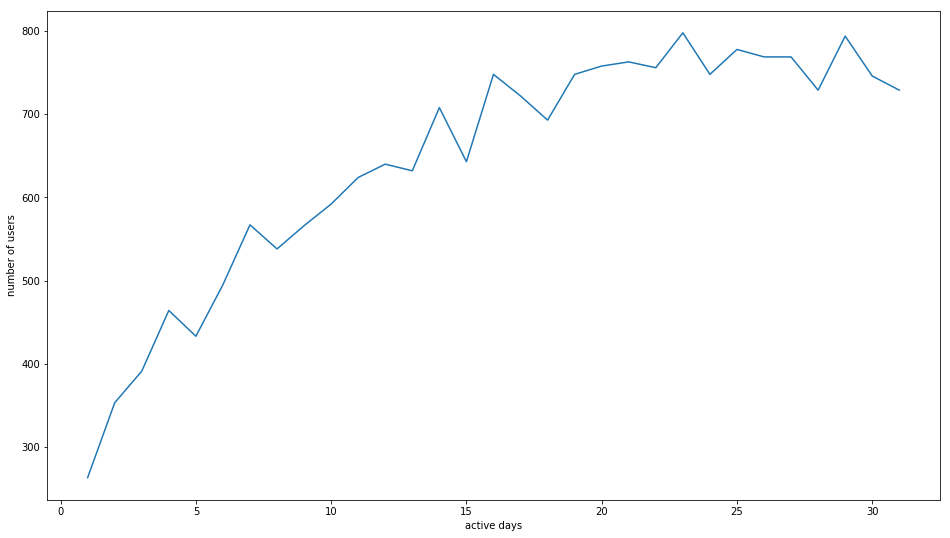

In [157]:
active_days = labels['30_active_days'].value_counts().sort_index(ascending=False)
plt.figure(figsize=(16, 9))
active_days.plot()
plt.xlabel('active days')
plt.ylabel('number of users')

In [161]:
# choose 15 as a threshold to divide users into 2 groups: less active(<=15), more active(>15)
# more active users than less active users
labels['active_level'] = labels['30_active_days'].apply(lambda x: 'high' if x > 15 else 'low')

Text(0,0.5,'number of users')

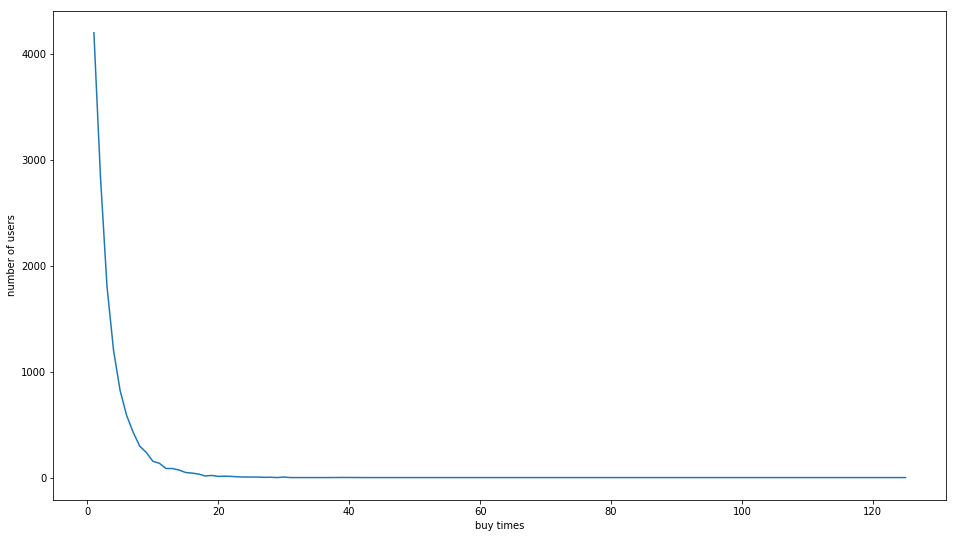

In [163]:
buy_times = labels['30_buy_counts'].value_counts().sort_index(ascending=False)
plt.figure(figsize=(16, 9))
buy_times.plot()
plt.xlabel('buy times')
plt.ylabel('number of users')

In [217]:
labels['buy_active_level'] = labels['30_buy_counts'].apply(lambda x: 'high' if x >= 14 else 'low' if pd.notna(x) else 'none')

In [166]:
df.head()

,user_id,item_id,behavior_type,item_category,time,date,time_int,hour_class
12419438,25630648,301411941,1,10392,2014-12-12 18,2014-12-12,18,下午
20497885,32417185,117974637,1,7660,2014-12-05 11,2014-12-05,11,中午
20966021,37346255,13299678,1,2415,2014-12-07 08,2014-12-07,8,上午
15740021,103725799,272758921,1,8387,2014-11-26 11,2014-11-26,11,中午
19003087,1436494,32923572,1,5388,2014-12-13 22,2014-12-13,22,晚上


In [167]:
df_buy = df[df['behavior_type'] == 4].groupby('user_id')['item_category'].nunique().reset_index()
df_buy.rename(columns={'item_category': 'buy_unique_categories'}, inplace=True)
labels = labels.merge(df_buy, how='left', on='user_id')
labels['only_buy_one_cate'] = labels['buy_unique_categories'].apply(lambda x: 'y' if x == 1 else 'n' if x > 1 else 'none')

In [168]:
labels.head()

,user_id,time_browse,time_buy,most_browsed_category,most_collected_category,most_carted_category,most_bought_category,30_buy_counts,30_cart_counts,30_active_days,...,browse_and_no_buy,browse_and_no_buy_flag,cart_and_no_buy,cart_and_no_buy_flag,buy_again,buy_times,active_level,buy_active_level,buy_unique_categories,only_buy_one_cate
0,25630648,下午,下午,9541,NaN,"2848,3502,8095,12294","5915,6745,12923",3.0,16.0,25,...,262.0,1,16.0,1,y,3.0,high,low,3.0,n
1,32417185,晚上,晚上,5232,"7660,9516","3064,9516",11537,14.0,45.0,30,...,469.0,1,41.0,1,y,14.0,high,high,13.0,n
2,37346255,晚上,NaN,5027,NaN,1863,NaN,NaN,7.0,22,...,103.0,1,7.0,1,none,NaN,high,low,NaN,none
3,103725799,下午,下午,"1560,8387","2828,5201,8161",NaN,8605,1.0,NaN,14,...,53.0,1,0.0,0,n,1.0,low,low,1.0,y
4,1436494,晚上,下午,11279,NaN,7957,7957,19.0,23.0,30,...,470.0,1,18.0,1,y,19.0,high,high,12.0,n


Text(0,0.5,'number of users')

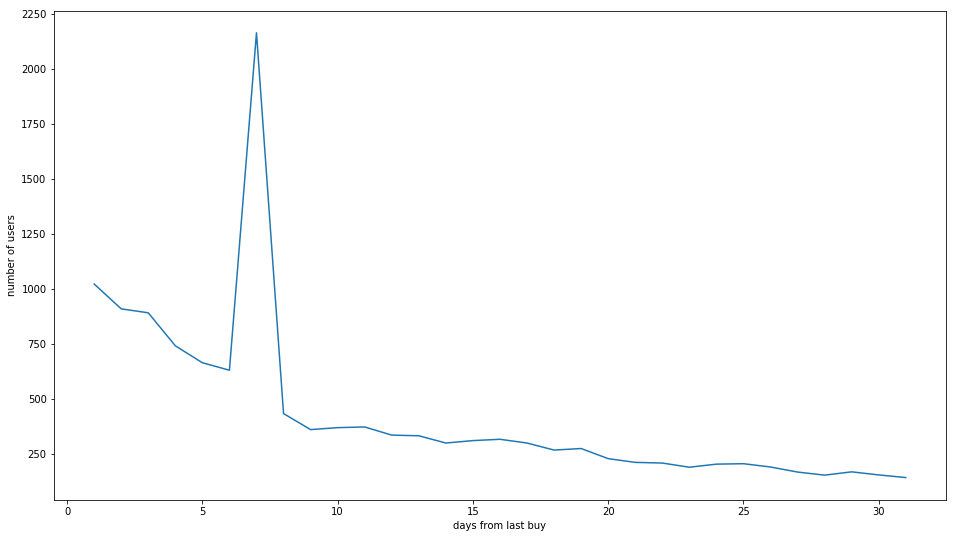

In [169]:
days_from_last_buy = labels['days_from_last_buy'].value_counts().sort_index(ascending=False)
plt.figure(figsize=(16, 9))
days_from_last_buy.plot()
plt.xlabel('days from last buy')
plt.ylabel('number of users')

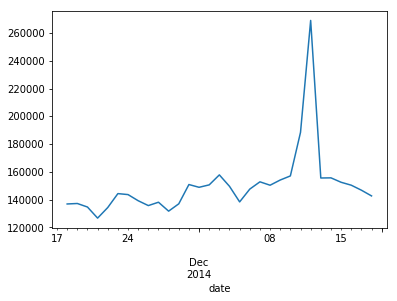

In [177]:
df.groupby('date')['user_id'].count().plot() # 12.12 causes a blast in users coming

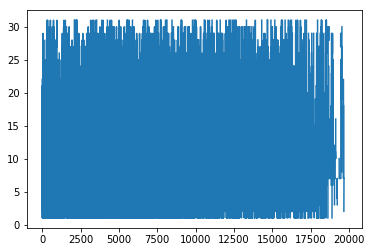

In [179]:
users_1212 = df.loc[df['date'] == datetime(2014, 12, 12), 'user_id'].unique()
days_from_last_buy_1212 = labels.loc[labels['user_id'].isin(users_1212), 'days_from_last_buy']

In [182]:
days_from_last_buy_1212.dropna().value_counts() # users on 12.12 mostly 7 days from last buy

7.0     2164
1.0      877
2.0      763
3.0      745
4.0      629
5.0      553
6.0      543
8.0      345
11.0     293
10.0     280
9.0      280
12.0     239
13.0     238
16.0     225
15.0     220
17.0     211
14.0     202
19.0     191
18.0     184
24.0     157
20.0     155
25.0     142
21.0     141
22.0     129
26.0     120
23.0     114
29.0     105
27.0     105
31.0      96
28.0      95
30.0      88
Name: days_from_last_buy, dtype: int64

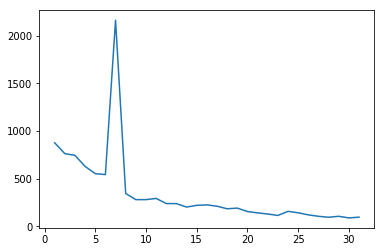

In [185]:
days_from_last_buy_1212.value_counts().sort_index(ascending=True).plot()

In [218]:
labels['buy_freq_level'] = labels['days_from_last_buy'].apply(lambda x: 'high' if x <= 7 else 'low' if pd.notna(x) else 'none')

In [219]:
# rfm
def rfm_analysis(row):
    if row['buy_active_level'] == 'high' and row['buy_freq_level'] == 'high':
        return 'important'
    elif row['buy_active_level'] == 'low' and row['buy_freq_level'] == 'high':
        return 'developing'
    elif row['buy_active_level'] == 'high' and row['buy_freq_level'] == 'low':
        return 'need to wake up'
    elif row['buy_active_level'] == 'none' and row['buy_freq_level'] == 'none':
        return 'has not bought yet'
    else:
        return 'losing'

In [220]:
labels['rfm_analysis'] = labels.apply(lambda row: rfm_analysis(row), axis=1)
labels['rfm_analysis'].value_counts()

has not bought yet    6752
developing            6718
losing                6159
important              303
need to wake up         25
Name: rfm_analysis, dtype: int64

In [221]:
labels.head()

,user_id,time_browse,time_buy,most_browsed_category,most_collected_category,most_carted_category,most_bought_category,30_buy_counts,30_cart_counts,30_active_days,...,cart_and_no_buy,cart_and_no_buy_flag,buy_again,buy_times,active_level,buy_active_level,buy_unique_categories,only_buy_one_cate,buy_freq_level,rfm_analysis
0,25630648,下午,下午,9541,NaN,"2848,3502,8095,12294","5915,6745,12923",3.0,16.0,25,...,16.0,1,y,3.0,high,low,3.0,n,low,losing
1,32417185,晚上,晚上,5232,"7660,9516","3064,9516",11537,14.0,45.0,30,...,41.0,1,y,14.0,high,high,13.0,n,high,important
2,37346255,晚上,NaN,5027,NaN,1863,NaN,NaN,7.0,22,...,7.0,1,none,NaN,high,none,NaN,none,none,has not bought yet
3,103725799,下午,下午,"1560,8387","2828,5201,8161",NaN,8605,1.0,NaN,14,...,0.0,0,n,1.0,low,low,1.0,y,low,losing
4,1436494,晚上,下午,11279,NaN,7957,7957,19.0,23.0,30,...,18.0,1,y,19.0,high,high,12.0,n,high,important
